# APPM 4720 Applied Deep Learning, Spring 2022
## Progress Report 04 - Multimodal Learning: Image Caption
### Show and Tell: A Neural Image Caption Generator
### By Sabrina Liu

Examined and implemented the **Neural Image Caption (NIC)** algorithm as described in 2015 Google paper *Show and Tell: A Neural Image Caption Generator*. Explored the `Flickr8K` dataset and explained the preprocessing steps in details. Trained the model and achieved some preliminary results. 

#### References:
* Paper: Vinyals, et.al. *Show and Tell: A Neural Image Caption Generator. 2015* https://arxiv.org/pdf/1411.4555
* Dataset: Flickr8K https://www.kaggle.com/adityajn105/flickr8k
* Tutorial: https://github.com/yashk2810/Image-Captioning/blob/master/Image%20Captioning%20InceptionV3.ipynb

The tutorial listed above provided some inspirations for the methods used to build the model. However, most of this project was hand-crafted from scratch. 

---
## Set Up Environment

#### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/ADL/ImageCaption'
!dir

/content/drive/MyDrive/ADL/ImageCaption
data  models


#### Configuratee GPU Usage

In [3]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Wed Mar  9 01:37:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
## Architecture Review

The Neural Image Caption (NIC) model was published by Vinyals, et.al., a group of scholars from Google, in 2015. The model combines techniques used in computer vision and machine translation to generate captions that describe the contents of images. The architecture is relatively simple, given prior knowledge about CNN and RNN strucutres. 

Specifically, given an input image, the model first feed the image into a CNN image classifier that outputs a global average pooling vector (before forwarding to dense layer and softmax). The image vector then is mapped to an embedding vector, similarly to word embeddings, and is used as a context vector jointly with all prior words for next word predcition through an LSTM. In mathematical representation:

$$ x_{-1} = \text{CNN}(I) $$
$$ x_t = W_e S_t, \quad t\in \{0,...,N-1\} $$
$$ p_{t+1} = \text{LSTM}(x_t), \quad t\in \{0,...,N-1\} $$

where $I$ is the image, $x_t$ is the sequence token embedding, $N$ is the length of the sequence, and $p_{t+1}$ is the next word prediction. The probability of the next token is modeled conditionally by

$$ \log p(S|I) = \sum_{t=0}^N \log p(S_t|I, S_0, \cdots, S_{t-1}) $$

The paper has included a really nice chart for the overall model architecture which is fairly intuitive. There will be more detailed explanations in the **Model Implementation** section below. 

---
## The Flickr8K Dataset

The `Flickr8k` dataset is commonly used for image captioning exercises. The dataset contains 8091 images, each with 5 different sets of annotations in a clean form. Both the images and the captions can be downloaded from https://www.kaggle.com/adityajn105/flickr8k. This is a very small dataset that allows us to quickly prototype a model and test its functionality. When capacity allows, we can train the model on larger datasets like `Microsfot COCO` or `Flickr30k` and only test on the smaller `Flickr8k`. Due to time and resource limitation, we only use `Flickr8k` here and further split it into train, validation and test datasets. 

#### Preview the Images
Let's take a look at the first few images along with their ground truth captions. The images come in various sizes and aspect ratios which requires preprocessing when feeding into the CNN. 

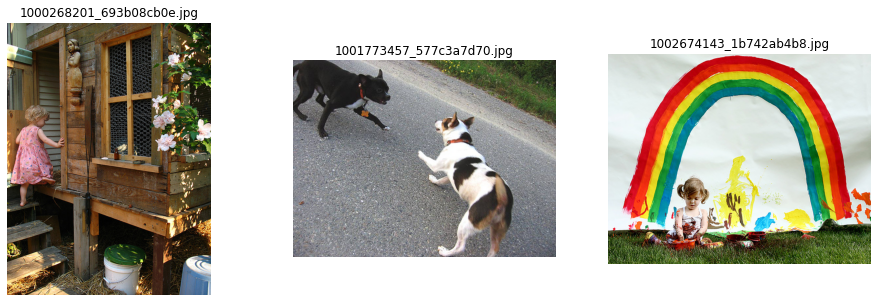

In [6]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

image_dir = './data/Flickr8K/images'
N_SAMPLES = 3

fig, axes = plt.subplots(1, N_SAMPLES, figsize=(16, 5))

for i, sample in enumerate(sorted(os.listdir(image_dir))[:N_SAMPLES]):
    img = np.array(Image.open(os.path.join(image_dir, sample)))
    axes[i].set(title=sample)
    axes[i].imshow(img)
    axes[i].axis('off')

#### Preview the Captions
It can be seen below that there are 5 different captions associated with each image that come from the original annotations text file. 

In [7]:
filepath = './data/Flickr8K/captions.txt'
texts = open(filepath, 'r', encoding = 'utf-8').read().splitlines()

texts = [line.split(',') for line in texts[1:]]
images = [line[0] for line in texts]
labels = [line[1] for line in texts]

display(images[:15])
display(labels[:15])

['1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1001773457_577c3a7d70.jpg',
 '1001773457_577c3a7d70.jpg',
 '1001773457_577c3a7d70.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1002674143_1b742ab4b8.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .',
 'A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails pain

In [8]:
display(len(images))
display(len(labels))

40455

40455

---
## Explorary Data Analysis
Before preprocessing, we will examine the vocabulary term frequency and sentence length distribution to determine the thresholds to use. These exercises have been repeatedly explained in previous projects so we can just directly apply them. 

#### Split Sentences into Words

In [9]:
import re

def split_to_words(sent):    
    words = re.split('[\d\W]+', sent)    # skip digits and symbols
    words = [w.lower() for w in words if w != '']
    return words

words = [split_to_words(line) for line in labels]
words[1:3]

[['a', 'girl', 'going', 'into', 'a', 'wooden', 'building'],
 ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse']]

In [10]:
len(words)

40455

#### Word Frequency
For computing efficiency, we will only keep words with a term frequency higher than 10. The assumption here is that omitting the rarely used words won't impact the annotation quality too much. This threshold can be lowered to 2 if we had more computing power. 

In [11]:
corpus = [word for line in words for word in line]
len(corpus)

419830

In [12]:
from collections import Counter
word_count = Counter(corpus)

# get unique count in the vocabulary
len(word_count)

8273

In [13]:
# get the 10 most common words
word_count.most_common(10)

[('a', 61436),
 ('in', 18193),
 ('the', 17677),
 ('on', 10369),
 ('is', 9069),
 ('and', 8066),
 ('dog', 7958),
 ('with', 7308),
 ('man', 7172),
 ('of', 6504)]

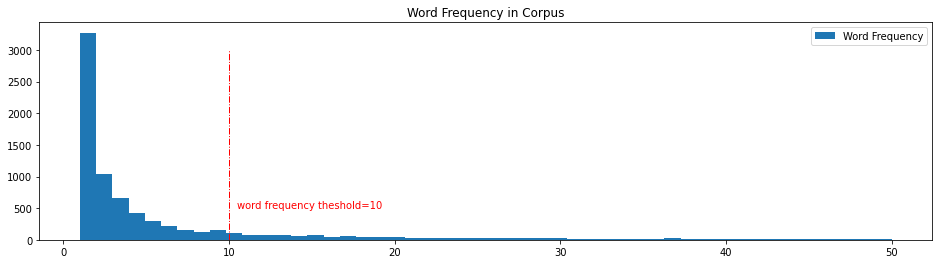

In [14]:
word_freq = np.array(list(dict(word_count).values()))

plt.rcParams["figure.figsize"] = (16, 4)
_ = plt.hist(word_freq, bins=50, range=(1, 50), label='Word Frequency')

plt.vlines(10, 0, 3000, colors='r', linewidth=1, linestyles='dashdot')
plt.text(10.5, 500, 'word frequency theshold=10', c='r')
plt.title('Word Frequency in Corpus')
plt.legend()
plt.show()

In [15]:
# get the 10 least common words
word_count.most_common()[:-11:-1]

[('patterns', 1),
 ('scrolled', 1),
 ('majestically', 1),
 ('weight', 1),
 ('spaniels', 1),
 ('cocker', 1),
 ('breezeway', 1),
 ('rainstorm', 1),
 ('containig', 1),
 ('swatting', 1)]

#### Get Vocabulary Size
After removing the low-frequency words from the vocabulary, we obtained a vocabulary size of 1805. For later tokenization purpose, we need to add 3 special tokens to the vocabulary: `<START>`, `<END>` and `<PAD>`, and increase the vocabulary size by 3 accordingly. 

In [16]:
FREQ_THRESH = 10

vocab = {word for line in words for word in line if word_count[word] > FREQ_THRESH}
len(vocab)

1805

In [17]:
VOCAB_SIZE = len(vocab) + 3   # add <START>, <END>, and <PAD> 
VOCAB_SIZE

1808

#### Get Sequence Length
The model expects text sequence inputs at even lengths. So we need a good threshold to pad/truncate the sentences. After a few trial and error rounds, it is decided that 13 is a good threshold. This will create sequences of length 15 after we add the `<START>` and `<END>` tokens. Again, if we had more computing power, we certainly would like to keep it longer. 

In [18]:
word_counts = [len(seq) for seq in words]
max(word_counts)

33

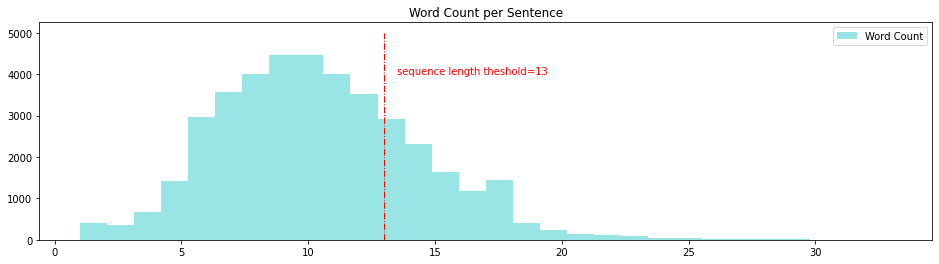

In [19]:
_ = plt.hist(word_counts, bins=30, color='c', alpha=.4, label='Word Count')

plt.vlines(13, 0, 5000, colors='r', linewidth=1, linestyles='dashdot')
plt.text(13.5, 4000, 'sequence length theshold=13', c='r')
plt.title('Word Count per Sentence')
plt.legend()
plt.show()

---
## Preprocessing

#### Convert Images into Arrays
For the CNN model we will be using pretrained `InceptionV3` available from `keras`. This requires the image input shape to be exactly `(299, 299, 3)`. We would like to keep the original aspect ratio when adjusting the size. Additionally, in order to match the images to their respective ground truth captions, we need to keep the indices in original order hence do not shuffle when preloading. The images are preloaded as arrays. 

In [20]:
IMAGE_SIZE = (299, 299)

Found 8091 files belonging to 1 classes.
(1, 299, 299, 3)
CPU times: user 825 ms, sys: 328 ms, total: 1.15 s
Wall time: 5.41 s


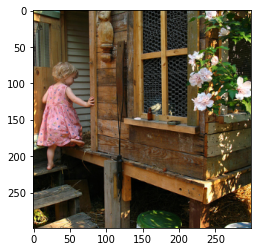

In [21]:
%%time

from tensorflow.keras.preprocessing import image_dataset_from_directory

image_arrays = image_dataset_from_directory(
    directory='./data/Flickr8K/images',
    batch_size=1,
    image_size=IMAGE_SIZE,
    label_mode=None,             # do not include labels
    shuffle=False,               # do not shuffle
    validation_split=None,       # do not split
    crop_to_aspect_ratio=True,   # do not distort image
)

for image_batch in image_arrays.take(1):
    print(image_batch.shape)
    _ = plt.imshow(image_batch[0]/255.)
    break

#### Tokenize Caption Labels
`keras` provides a tokenizer that conveniently converts texts into tokens. It reserses the label 0 for the empty string `''` so we would like to understand the empty string as a padded space in place of the `<PAD>` token below, which also semantically make sense when decoded back into text. The tokenizer assigns indices based on word frequency in descending order, therefore artificial repetitions are applied to the special tokens to assure they get the desired encoding. As shown below, `<START>` gets 1, and `<END>` gets 2. But we will add them after making the sequences into the same length. 

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [22]:
from keras.preprocessing.text import Tokenizer

start = ['<START>']
end = ['<END>']
special_tokens = start * 63000 + end * 62000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=None)
tokenizer.fit_on_texts([special_tokens] + words)

tokens = tokenizer.texts_to_sequences(words)

tokenizer.sequences_to_texts([[0], [1], [2], [3], [4], [5]])

['', '<start>', '<end>', 'a', 'in', 'the']

In [23]:
words[0][:10]

['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a']

In [24]:
tokenizer.sequences_to_texts([tokens[0][:10]])

['a child in a pink dress is climbing up a']

#### Add Sentence Padding (or Truncate)

Now we will pad the sequences shorter than 13 with trailing 0s and truncate those that are longer. Then we will add token 1 at the beginning and token 2 at the end to indicate `<START>` and `<END>`. Note that we need to first convert the sequences into lists (instead of array) to ensure concatenation and avoid element-wise operation. 

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

In [25]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 15

# leave space for <START> and <END>
tokens = pad_sequences(tokens, maxlen=MAX_LEN - 2, padding='post', value=0)
print(tokens[0])
tokens = [[1] + list(line) + [2] for line in tokens]
print(tokens[0])

[  3  88 172   7 115  51   3 388  12 384   4  28 669]
[1, 3, 88, 172, 7, 115, 51, 3, 388, 12, 384, 4, 28, 669, 2]


#### Split Dataset Train-Validation-Test

The dataset contains a total of 8091 images. We will use 4000 for training, 3000 for validation, and the remaining 1091 for scoring. 

In [26]:
len(image_arrays)

8091

In [27]:
%%time

arrays = list(image_arrays.as_numpy_iterator())

CPU times: user 42.6 s, sys: 7.87 s, total: 50.5 s
Wall time: 1min 57s


In [28]:
images_train = arrays[:4000]
images_valid = arrays[4000:7000]
images_test = arrays[7000:]

print(len(images_train))
print(len(images_valid))
print(len(images_test))

del(arrays)

4000
3000
1091


In [29]:
len(tokens)

40455

In [30]:
tokens = list(zip(*[iter(tokens)]*5))
len(tokens)

8091

In [31]:
tokens_train = tokens[:4000]
tokens_valid = tokens[4000:7000]
tokens_test = tokens[7000:]

print(len(tokens_train))
print(len(tokens_valid))
print(len(tokens_test))

4000
3000
1091


#### Verify Training Vocabulary Size

Even though we fit the tokens with a vocabulary size of 1808, we might not have the same vocabulary after spliting the dataset. 

In [32]:
vocab_train = {word for img in tokens_train for line in img for word in line}
len(vocab_train)

1796

In [33]:
len(vocab) - len(vocab_train) + 3

12

Looks like we are only leaving 12 words out for training by spliting the dataset this way. Got lucky! 

#### Generate Next Word Prediction

In order to train the LSTM model to generate captions, we use the next word prediction framework. That is, given the first word is always the `<START>` token, we want the LSTM model to predict the next word when the image vector is also given, and repeat the above process. This is a recursive process since the prediction of each next word requires seeing both the image and all previous words. When the output is the `<END>` token, the prediction stops. Here the training and validation data are both processed into the format to facilitate this step-wise prediction. 

In [34]:
%%time

def get_next_word(line):
    tokens_lead_all = []
    tokens_next_all = []

    for i in range(MAX_LEN - 1):
        tokens_lead = line[:i+1].copy()
        tokens_lead = pad_sequences([tokens_lead], maxlen=MAX_LEN, padding='post', value=0)[0]
        tokens_lead_all.append(tokens_lead)

        tokens_next = line[i+1]
        tokens_next = tf.one_hot(tf.cast(tokens_next, tf.int32), VOCAB_SIZE)
        tokens_next_all.append(tokens_next)

    return tokens_lead_all, tokens_next_all

tokens_train_steps = [get_next_word(cap) for img in tokens_train for cap in img]
tokens_valid_steps = [get_next_word(cap) for img in tokens_valid for cap in img]

CPU times: user 2min 7s, sys: 14.8 s, total: 2min 22s
Wall time: 2min 2s


In [35]:
tokens_train_steps[0][0][0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [36]:
tokens_train_steps[0][1][0]

<tf.Tensor: shape=(1808,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

#### Make Batched Dataset

Now we transform the above images and tokens into batch datasets that can be taken by tensorflow `fit` method. 

In [37]:
len(images_train)

4000

In [38]:
tokens_train_lead, tokens_train_next = zip(*tokens_train_steps)
tokens_valid_lead, tokens_valid_next = zip(*tokens_valid_steps)

In [39]:
tokens_train_lead = list(zip(*[iter(tokens_train_lead)]*5))
tokens_train_next = list(zip(*[iter(tokens_train_next)]*5))

tokens_valid_lead = list(zip(*[iter(tokens_valid_lead)]*5))
tokens_valid_next = list(zip(*[iter(tokens_valid_next)]*5))

len(tokens_train_lead)

4000

In [40]:
BATCH_SIZE = 10

In [41]:
%%time

x = tf.data.Dataset.from_tensor_slices(np.array(images_train)).batch(BATCH_SIZE)
y = tf.data.Dataset.from_tensor_slices(np.array(tokens_train_lead)).batch(BATCH_SIZE)
z = tf.data.Dataset.from_tensor_slices(np.array(tokens_train_next)).batch(BATCH_SIZE)

ds_train = tf.data.Dataset.zip((x, y, z))

CPU times: user 20.4 s, sys: 9.99 s, total: 30.4 s
Wall time: 19.6 s


In [42]:
%%time

x = tf.data.Dataset.from_tensor_slices(np.array(images_valid)).batch(BATCH_SIZE)
y = tf.data.Dataset.from_tensor_slices(np.array(tokens_valid_lead)).batch(BATCH_SIZE)
z = tf.data.Dataset.from_tensor_slices(np.array(tokens_valid_next)).batch(BATCH_SIZE)

ds_valid = tf.data.Dataset.zip((x, y, z))

CPU times: user 15.6 s, sys: 7.38 s, total: 23 s
Wall time: 14.9 s


---
## Model Implementation

Below is a simple prototype version of the Neural Image Caption model, with simplified framework and reduced parameters to illustrate the logic. The model mainly includes 4 modules:
1. **Image Encoder**: defined in `image_model`. This module is the CNN image classifier that converts the input image into a vector of fixed length. A pretrained model `InceptionV3` is used for this purpose without the classification head. 
2. **Image Embedding**: defined in `image_embed`. This module takes in the above output image vector and converts it into an embedding vector to be consistent with the token embeddings. 
3. **Token Embedding**: defined in `token_embed`. This module takes in sequences of fixed length `MAX_LEN` and converts them into one-hot vectors of length `VOCAB_SIZE` before mapping into token embeddings. 
4. **Caption Generator**: defined in `final_model`. This is the model that takes in the concatenated image and token embedding vectors and outputs a single token for next word prediction. The output is a softmax distribution over the `VOCAB_SIZE` for cross-entropty calculation. 

The input and output dimensions of each of the modules are displayed in the summary section below the definitions. The training process and the loss calculation are defined in **custom training loop** later. 

In [43]:
EMBEDDING_SIZE = 64

In [44]:
print("IMAGE_SIZE:".ljust(16), IMAGE_SIZE)
print("FREQ_THRESH:".ljust(16), FREQ_THRESH)
print("VOCAB_SIZE:".ljust(16), VOCAB_SIZE)
print("MAX_LEN:".ljust(16), MAX_LEN)
print("EMBEDDING_SIZE:".ljust(16), EMBEDDING_SIZE)
print("BATCH_SIZE:".ljust(16), BATCH_SIZE)

IMAGE_SIZE:      (299, 299)
FREQ_THRESH:     10
VOCAB_SIZE:      1808
MAX_LEN:         15
EMBEDDING_SIZE:  64
BATCH_SIZE:      10


In [45]:
from keras import backend as K
K.clear_session()

#### Image Encoder

In [46]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D

def image_model(input_shape=(299, 299, 3), summary=False):

    x = Input(shape=input_shape, name='input')

    backbone = InceptionV3(weights='imagenet', include_top=False)
    z = backbone(x)
    z = GlobalAveragePooling2D(name='ap')(z)

    model = Model(inputs=x, outputs=z, name='ImageEncoder')

    if summary:
        display(model.summary())
    return model

_ = image_model(summary=True)

87924736/87910968 [==============================] - 2s 0us/step
Model: "ImageEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 ap (GlobalAveragePooling2D)  (None, 2048)             0         
                                                                 
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________


None

#### Image Embedding

In [47]:
from tensorflow.keras.layers import Dense

def image_embed(input_shape=(2048, ), summary=False):
    
    x = Input(shape=input_shape, name='input')

    z = Dense(EMBEDDING_SIZE, activation='relu', name='dense')(x)
    
    model = Model(inputs=x, outputs=z, name='ImageEmbedding')

    if summary:
        display(model.summary())
    return model

_ = image_embed(summary=True)

Model: "ImageEmbedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2048)]            0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
Total params: 131,136
Trainable params: 131,136
Non-trainable params: 0
_________________________________________________________________


None

#### Token Embedding

In [48]:
from tensorflow.keras.layers import Embedding

def token_embed(input_shape=(MAX_LEN, ), summary=False):
    
    x = Input(shape=input_shape, name='input')

    z = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, input_length=MAX_LEN, name='token_embed')(x)

    model = Model(inputs=x, outputs=z, name='TokenEmbedding')

    if summary:
        display(model.summary())
    return model

_ = token_embed(summary=True)

Model: "TokenEmbedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15)]              0         
                                                                 
 token_embed (Embedding)     (None, 15, 64)            115712    
                                                                 
Total params: 115,712
Trainable params: 115,712
Non-trainable params: 0
_________________________________________________________________


None

#### Caption Generator

In [49]:
from tensorflow.keras.layers import LSTM

def final_model(input_shape=(MAX_LEN+1, EMBEDDING_SIZE), summary=False):
    
    x = Input(shape=input_shape, name='input')

    z = LSTM(64, return_sequences=False, name='LSTM')(x)
    z = Dense(VOCAB_SIZE, activation='softmax', name='output')(z)

    model = Model(inputs=x, outputs=z, name='CaptionGenerator')
    
    if summary:
        display(model.summary())
    return model

_ = final_model(summary=True)

Model: "CaptionGenerator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 16, 64)]          0         
                                                                 
 LSTM (LSTM)                 (None, 64)                33024     
                                                                 
 output (Dense)              (None, 1808)              117520    
                                                                 
Total params: 150,544
Trainable params: 150,544
Non-trainable params: 0
_________________________________________________________________


None

#### Customized Training Loop

Due to the reason that the image embedding is shared for all token steps and each image correspond to 5 different captions and each caption comes with `MAX_LEN - 1` time steps in the training, we repeat the image embedding vector prior to concatenating to the token embeddings before feeding them into the LSTM during the custom training loop. Each next word prediction is taken into the loss (cross-entropy) against ground truth. This is more efficient than calculating the loss using a for-loop. 

For inference time, as defined under the `__call__` method, we take in only the image array and define the first token to be `<START>`, then feed the image the initial token through the same model to predict one word at a time until the output is the `<END>` token or `MAX_LEN` is reached. Due to time limitation, the beam search is not implemented. 

In [50]:
tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)  # required to use tensor.numpy()

In [51]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

criterion = CategoricalCrossentropy()
train_loss = tf.keras.metrics.CategoricalCrossentropy(name="train_loss")
valid_loss = tf.keras.metrics.CategoricalCrossentropy(name="valid_loss")

class NeuralImageCaption(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.image_model = image_model()
        self.image_embed = image_embed()
        self.token_embed = token_embed()
        self.final_model = final_model()
        
    def compile(self):
        compile_dict=dict(
            loss='categorical_crossentropy',
            optimizer=Adam(),
            metrics=['accuracy'],
        )
        super().compile(**compile_dict)
    
    def train_step(self, data):
        # images: (B, 1, 299, 299, 3)
        # tokens_lead: (B, 5, 14, 15)
        # tokens_next: (B, 5, 14, VOCAB)
        images, tokens_lead, tokens_next = data
        images /= 255.
        images = tf.squeeze(images)
    
        with tf.GradientTape() as tape:

            image_vecs = self.image_model(images, training=False)        # out: (B, 2048)
            image_vecs = self.image_embed(image_vecs, training=True)     # out: (B, EMBED)
            image_vecs = tf.expand_dims(image_vecs, axis=1)              # out: (B, 1, EMBED)            
            image_vecs = tf.repeat(image_vecs, 5 * (MAX_LEN-1), axis=0)  # out: (B*70, 1, EMBED)

            tokens_lead = tf.reshape(tokens_lead, (-1, MAX_LEN))         # out: (B*70, 15)
            token_vecs = self.token_embed(tokens_lead, training=True)    # out: (B*70, 15, EMBED)

            input_vecs = tf.concat((image_vecs, token_vecs), axis=1)     # out: (B*70, 16, EMBED)
            token_pred = self.final_model(input_vecs, training=True)     # out: (B*70, VOCAB)
            token_true = tf.reshape(tokens_next, (-1, VOCAB_SIZE))       # out: (B*70, VOCAB)

            loss = criterion(token_true, token_pred)

            trainable = self.image_embed.trainable_variables \
                      + self.token_embed.trainable_variables \
                      + self.final_model.trainable_variables

            gradients = tape.gradient(loss, trainable)

            self.optimizer.apply_gradients(
                (grad, vars) for (grad, vars) in zip(gradients, trainable)
                if grad is not None
            )

            train_loss.update_state(token_true, token_pred)

            results = {m.name: m.result() for m in self.metrics}
            results.update(dict(loss=loss))

        return results

    def test_step(self, data):
        images, tokens_lead, tokens_next = data
        images /= 255.
        images = tf.squeeze(images)

        image_vecs = self.image_model(images, training=False)        # out: (B, 2048)
        image_vecs = self.image_embed(image_vecs, training=False)    # out: (B, EMBED)
        image_vecs = tf.expand_dims(image_vecs, axis=1)              # out: (B, 1, EMBED)
        image_vecs = tf.repeat(image_vecs, 5 * (MAX_LEN-1), axis=0)  # out: (B*70, 1, EMBED)

        tokens_lead = tf.reshape(tokens_lead, (-1, MAX_LEN))         # out: (B*70, 15)
        token_vecs = self.token_embed(tokens_lead, training=False)   # out: (B*70, 15, EMBED)

        input_vecs = tf.concat((image_vecs, token_vecs), axis=1)     # out: (B*70, 16, EMBED)
        token_pred = self.final_model(input_vecs, training=False)    # out: (B*70, VOCAB)
        token_true = tf.reshape(tokens_next, (-1, VOCAB_SIZE))       # out: (B*70, VOCAB)

        loss = criterion(token_true, token_pred)
        valid_loss.update_state(token_true, token_pred)          

        results = {m.name: m.result() for m in self.metrics}
        results.update(dict(loss=loss))

        return results

    def __call__(self, image, training=False):    # takes single image
        image /= 255.
        image = tf.reshape(image, (-1, 299, 299, 3))

        image_vecs = self.image_model(image, training=False)           # out: (1, 2048)
        image_vecs = self.image_embed(image_vecs, training=False)      # out: (1, EMBED)
        image_vecs = tf.expand_dims(image_vecs, axis=1)                # out: (1, 1, EMBED)

        tokens = tf.cast(tf.ones((1, 1)), tf.int32)      # <START>     # out: (1, 1)
        while True:
            empty_zero = tf.cast(tf.zeros((1, MAX_LEN - tokens.shape[-1])), tf.int32)
            token_lead = tf.concat((tokens, empty_zero), axis=-1)      # out: (1, 15)
            token_vecs = self.token_embed(token_lead, training=False)  # out: (1, 15, EMBED)
            input_vecs = tf.concat((image_vecs, token_vecs), axis=1)   # out: (1, 16, EMBED)
            token_pred = self.final_model(input_vecs, training=False)  # out: (1, VOCAB)
            token_next = tf.argmax(token_pred, axis=-1)                # out: (1, )
            token_next = tf.reshape(tf.cast(token_next, tf.int32), (1, 1))
            tokens = tf.concat((tokens, token_next), axis=-1)

            if (token_next[0][0].numpy() == 2): break     # <END>
            if (tokens.shape[-1] == MAX_LEN): break

        return tokens

model = NeuralImageCaption()
model.compile()

---
## Training

The model is trained for 100 epochs and the weights are saved for re-use. The model will directly use the pretrained weights if they are available. 

In [52]:
import os
import pickle

model_name = "image_caption"
model_file = f"./models/{model_name}.tf"
hist_file = "./models/model_history.pkl"

if not os.path.exists('./models'):
    os.mkdir('./models')

# use pre-trained model if available
if os.path.exists(f"{model_file}.index") and os.path.exists(hist_file):
    print(f"\nLoading model weights for {model_file}...")
    model.load_weights(model_file)
    print(f"\nLoading model history for {model_name}...")
    with open(hist_file, 'rb') as pickle_file:
        model_history = pickle.load(pickle_file)
else:

    N_EPOCHS = 100
    N_WORKERS = 200

    fit_dict = dict(
        shuffle=True,
        batch_size=BATCH_SIZE, 
        epochs=N_EPOCHS, 
        verbose=1,
        workers=N_WORKERS, 
        use_multiprocessing=True
    )

    print(f"\nTraining model {model_name}...")
    history = model.fit(ds_train, validation_data=ds_valid, **fit_dict)
    model_history = history.history

    print(f"\nSaving model weights for {model_name}...")
    model.save_weights(model_file)

    print(f"\nSaving model history for {model_name}...")
    with open('./models/model_history.pkl', 'wb') as pickle_file:
        pickle.dump(model_history, pickle_file)


Loading model weights for ./models/image_caption.tf...

Loading model history for image_caption...


#### Training and Validation Performance

Based on the training history, it can be observed that the training and validation losses start to slowly diverge after about 40 epochs, even though the training loss keeps decreasing. This indicates that the model might have been overfit, which is expected since we have used a small dataset. 

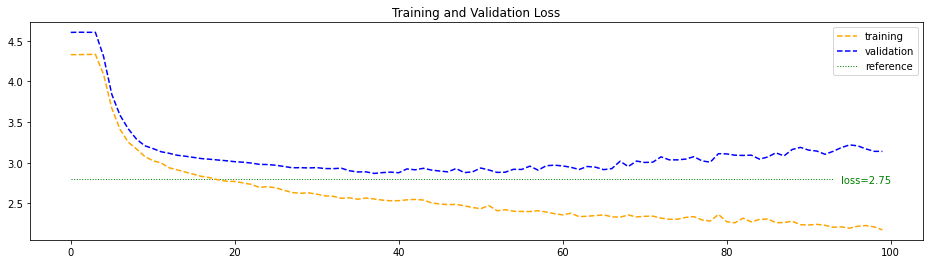

In [53]:
plt.figure(figsize=(16, 4))

_ = plt.plot(model_history['loss'], color='orange', linestyle='--', label='training')
_ = plt.plot(model_history['val_loss'], color='blue', linestyle='--', label='validation')
plt.hlines(2.8, 0, 93, colors='g', linewidth=1, linestyles='dotted', label='reference')
plt.text(94, 2.75, 'loss=2.75', c='g')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

---
## Evaluation

#### Predict One

Let's first take one example from the test dataset and check out how the prediction works. 

In [54]:
id = 0
test_img = images_test[id]
test_img.shape

(1, 299, 299, 3)

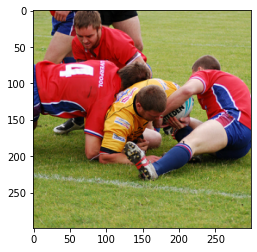

In [55]:
_ = plt.imshow(test_img[0]/255.)

In [56]:
# ground truth
tokenizer.sequences_to_texts(tokens_test[id])

['<start> four rugby players on the ground with two standing behind them <end>',
 '<start> members of two soccer teams on the field to get the ball <end>',
 '<start> soccer players on the ground fighting for the ball <end>',
 '<start> rugby players in red are wrestling the player in yellow to the ground <end>',
 '<start> red team are in the grass with a member of the yellow team <end>']

In [57]:
pred = model.predict(test_img)
pred

array([[  1,   3,  55,  12, 120, 192,   4,  14, 387,   0,   0,   0,   0,
          0,   0]], dtype=int32)

In [58]:
# prediction
tokenizer.sequences_to_texts(pred)

['<start> a group of football players in white uniforms']

This caption mostly makes sense to me except for being a little color-blind! It's hard even for human to tell what exact ball sports they are playing. 

#### Predict All Test Data

Now, let's predict with all the test images and preview the first 5. 

In [59]:
len(images_test)

1091

In [60]:
%%time

from tqdm import trange

captions = []

for i in trange(len(images_test)):
    img = images_test[i]
    caption = model.predict(img)
    captions.append(caption)

100%|██████████| 1091/1091 [03:50<00:00,  4.73it/s]

CPU times: user 3min 53s, sys: 7.71 s, total: 4min
Wall time: 3min 50s


In [61]:
captions[0]

array([[  1,   3,  55,  12, 120, 192,   4,  14, 387,   0,   0,   0,   0,
          0,   0]], dtype=int32)

In [62]:
captions = [list(np.squeeze(line))[1:] for line in captions]    # remove <START>
captions[0]

[3, 55, 12, 120, 192, 4, 14, 387, 0, 0, 0, 0, 0, 0]

In [63]:
captions_pred = tokenizer.sequences_to_texts(captions)
captions_pred[:5]

['a group of football players in white uniforms',
 'a woman in a black jacket is sitting on a bench',
 'a dog',
 'a man is standing in front of a',
 'a man in a white shirt and blue shorts is smiling']

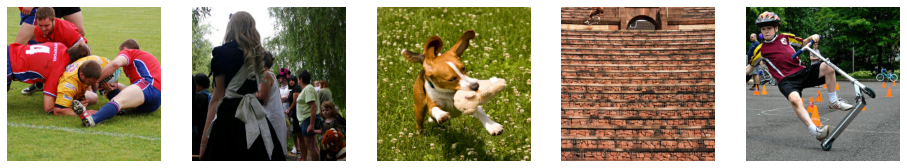

In [64]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4))
for i in range(5):
    _ = axes[i].imshow(images_test[i][0]/255.)
    axes[i].axis('off')

In [65]:
captions_true = []

for tok in tokens_test:
    # use indices to remove <START> and <END> from pre-processed ground truth
    caps_true = [line[8:-6] for line in tokenizer.sequences_to_texts(tok)]
    captions_true.append(caps_true)

captions_true[:5]

[['four rugby players on the ground with two standing behind them',
  'members of two soccer teams on the field to get the ball',
  'soccer players on the ground fighting for the ball',
  'rugby players in red are wrestling the player in yellow to the ground',
  'red team are in the grass with a member of the yellow team'],
 ['black dress and big white bow stands with her back to the camera',
  'many people gather outside',
  'people stand outside watching something',
  'people with costumes are gathered in a wooded area looking the same direction',
  'the back of a woman in costume little girl looks at her'],
 ['dog is playing with a toy in a field of green grass and',
  'a brown and white dog retrieving a white toy in a field of',
  'a photo of a playing dog in a flower field',
  'a dog in grass carrying a toy in its mouth',
  'dog is running through a field with a white object in its mouth'],
 ['a runs up brick stairs for training',
  'a man is skating down a set of stairs',
  'a sk

#### BLEU Score

BLEU Score, or the BiLingual Evaluation Understudy Score, is usually used for evaluating machine translation models. Image captioning is similar in a way to machine translation since the ground truth is available. The score is a metric for sequence-to-sequence similarity comparison. 

The score is mathematically defined as the geometric average of n-gram precision scores with a brevity penalty on not enough words. The precision score for each parsing level i-gram is TP/(TP+FP), i.e. the number of correct i-grams predicted that match the ground truth text out of the model output. Below is the formula with . Since it's impractical to measure recall (false negatives) with many unused words from the vocabulary, there is a penalty with exponential decay to make sure the model translation did not leave out too many words. The penalty term equals 1 (no penalty) when the lengths match, and decreases exponentially as the length of output sequence deviate away from the ground truth and get too short. There is no penalty if it gets too long but using too many unnecessary words will hurt precision. The precision could be 0 so the BLEU score is always between 0 and 1 but often reported in percentages.

$$\text{BLEU} = \underbrace{\min\left(1, \exp\left(1-\frac{Length_\text{true}}{Length_\text{pred}}\right)\right)}_{\text{brevity penalty}}
\underbrace{\left(\prod_1^4 Precision_i \right)^{1/4}}_{\text{n-gram overlap}} $$

* Google Translate Documentation https://cloud.google.com/translate/automl/docs/evaluate
* NLTK BLEU Score Implementation https://www.nltk.org/_modules/nltk/translate/bleu_score.html
* NLTK BLEU Score Documentation https://www.nltk.org/api/nltk.translate.bleu_score.html

`NLTK` library provides an easy-to-implement BLEU score function, with example shown below.

In [66]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

sent1 = ['it', 'is', 'such', 'a', 'good', 'day']
sent2 = ['it', 'is', 'such', 'a', 'nice', 'day']
sent3 = ['what', 'very', 'nice', 'day']
sent4 = ['good', 'day']

# use sent1 and sent2 as ground truth
from functools import partial
score = partial(sentence_bleu, references=[sent1, sent2], smoothing_function=SmoothingFunction().method1)

for sent in [sent1, sent2, sent3, sent4]:
    print('%.2f' % score(hypothesis=sent))

1.00
1.00
0.10
0.04


From above example, `sent1` and `sent2` are both used as ground truth hence got score 1. `sent3` and `sent4` each got only 2 words correct, but the score for sent4 is much lower due to brevity penalty. Now we will run the BLEU score function over all the predictions. For each prediction, all 5 ground truth sequences are used for scoring. 

In [67]:
%%time

score = partial(sentence_bleu, smoothing_function=SmoothingFunction().method1)

scores = []

for true, pred in zip(captions_true, captions_pred):
    current_score = score(references=true, hypothesis=pred)
    scores.append(current_score)

CPU times: user 813 ms, sys: 0 ns, total: 813 ms
Wall time: 807 ms


In [68]:
avg_score = sum(scores) / len(scores)
avg_score

0.3974593540825839

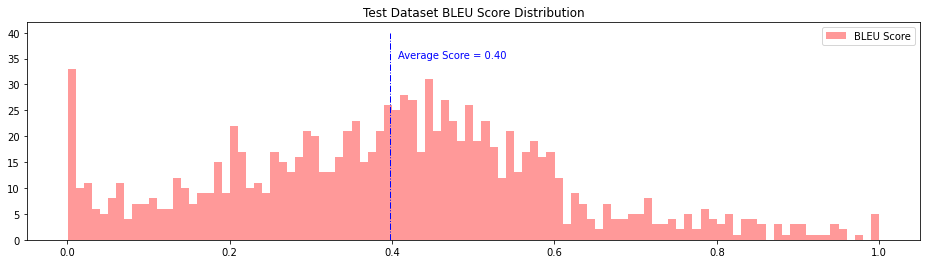

In [69]:
_ = plt.hist(scores, bins=100, color='r', alpha=.4, label='BLEU Score')

plt.vlines(avg_score, 0, 40, colors='b', linewidth=1, linestyles='dashdot')
plt.text(avg_score + 0.01, 35, f'Average Score = {avg_score:.2f}', c='b')
plt.title('Test Dataset BLEU Score Distribution')
plt.legend()
plt.show()

The average BLEU score we got is about 40%, not a bad performance for the short time used. Above histogram shows the test score distribution, which has a strong central tendency around the mean. Note that the BLEU score baseline for image caption task is different from machine translation, since there are many ways to interpret an image. Also, the image captions often contain high-frequency words like articles and prepositions, which tend to slightly contribute to the BLEU scores. 